# Credit-Card Default Risk
#### by Perry Shyr
## _2-of-7. Exploratory Data Analysis_
![](../images/cards.png)

## Problem Statement

### Credit-card lenders need help in detecting default-risk anomalies.   Customer demographic and borrowing history is studied and modeled to identify credit-card default risk.  The misclassifications must be carefully considered when making decisions affecting both loss mitigation and customer retention.  This is a supervised binary-classification problem with customers who default as the positive class, and unbalanced classes.  The baseline model predicts slightly more than 22% with default risk.  models should ideally be optimized to reduce false-negatives in applicant screening and false-positives active loss mitigation.

## Executive Summary

### Financial losses from credit-card default are a big part of the cost of doing business as a consumer lender.  However, decisions based on identifying default risk must be made delicately to balance customer-retention interests.  A canonical dataset for credit-card borrowing history was used to train several predictive models for default risk.  Combining an easily-interpretable model with neural-network-based ones can lead to a robust solution for minimizing misclassifications.  A ‘logcosh’ loss-function was found to be effective for minimizing False-negative misclassifications while a ‘mean-squared-logarithmic-error’ loss function works to minimize False-positive misclassifications.  The former ‘logcosh’ model is also good at finding True-positives.  The logistic-regression model can find the strongest feature predictors which can be re-fed into the neural-network models to produce a better result.


## A. Code Libraries Used

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## B. Load Data from Notebook-1

### Let's use a more descriptive name for our data, like 'accts' for accounts.

In [3]:
accts = pd.read_csv('../assets/credit_data_processed.csv', index_col='ID')

### Let's verify the shape and head of our dataframe.

In [7]:
print(accts.shape)
accts.head()

(29965, 24)


,credit_limit,gender,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Oct_Default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Let's look at the distribution of the target variable:

In [10]:
accts['Oct_Default'].value_counts()/accts.shape[0]

0    0.778742
1    0.221258
Name: Oct_Default, dtype: float64

### This confirms our target classes; "1" for the positive class and "0" for the negative class.

## C. Baseline Model

### We are not ready to start modeling, but we might as well state out baseline model.  A random estimator should be able to generalize the class based simply on the distribution of 'Oct_Default,' our target variable.  That is, our baseline model predicts default 22.12% of the time.

## D. Data Exploration

### Let's start with the 'gender'-feature column:
### We are interested in the proportion of accounts by gender and target-default.  Let's assign these to a new dataframe, 'mf.'

In [21]:
mf = pd.crosstab(accts['gender'], accts['Oct_Default'])
mf   # 'mf' for 'Male:Female'

Oct_Default,0,1
gender,,
1,9005,2869
2,14330,3761


Text(0.5, 0, 'Gender')

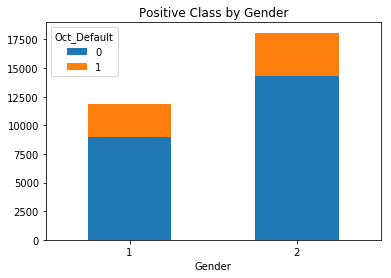

In [22]:
mf.plot(kind='bar', stacked=True, title='Positive Class by Gender', rot=0)
plt.xlabel("Gender")

### We can see from a quick plot how accounts breakdown by gender and target-status.

### Let's look at this in a slightly different way, normalizing for the number of accounts.

In [37]:
mf.loc[1,:] = mf.loc[1,:]/mf.loc[1,:].sum()
mf.loc[2,:] = mf.loc[2,:]/mf.loc[2,:].sum()
mf

Oct_Default,0,1
gender,,
1,0.758380,0.241620
2,0.792107,0.207893


### We see the percentages, but it's unclear which is which from the indices.  Let's rename the indices:

In [38]:
mf = mf.rename(columns={0:'Non-default',1:'Default'})
mf = mf.rename(index={1:'Male',2:'Female'})
mf.reindex()

Oct_Default,Non-default,Default
gender,,
Male,0.758380,0.241620
Female,0.792107,0.207893


### That's easier to understand.  Let's plot it now.

Text(0.5, 0, 'Gender')

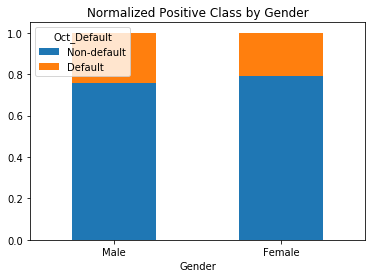

In [39]:
mf.plot(kind='bar', stacked=True, title='Normalized Positive Class by Gender', rot=0)
plt.xlabel("Gender")

### What we can see from this is that the default rate is slightly greater for men than it is for women.  By just plotting stacked-bars to find that there are significantly more female account-holders than men, it would not have been clear what the risk-profiles looked like.

### Let's do the same for the 'EDUCATION' column.

Text(0.5, 0, 'Education Level')

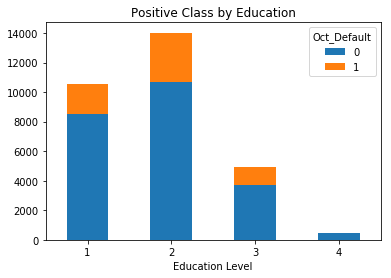

In [43]:
ed = pd.crosstab(accts['EDUCATION'], accts['Oct_Default'])
ed.plot(kind='bar', stacked=True, title='Positive Class by Education', rot=0)
plt.xlabel("Education Level")

Text(0.5, 0, 'Education Level')

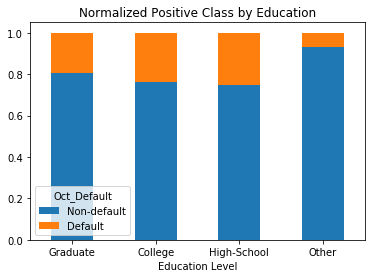

In [44]:
ed.loc[1,:] = ed.loc[1,:]/ed.loc[1,:].sum()
ed.loc[2,:] = ed.loc[2,:]/ed.loc[2,:].sum()
ed.loc[3,:] = ed.loc[3,:]/ed.loc[3,:].sum()
ed.loc[4,:] = ed.loc[4,:]/ed.loc[4,:].sum()
ed = ed.rename(columns={0:'Non-default',1:'Default'})
ed = ed.rename(index={1:'Graduate',2:'College',3:'High-School',4:'Other'})
ed.plot(kind='bar', stacked=True, title='Normalized Positive Class by Education', rot=0)
plt.xlabel("Education Level")

### We can see visually that the risk-profile appears to drop with the level of advanced education.

### For Marital-Status?

Text(0.5, 0, 'Marital Status')

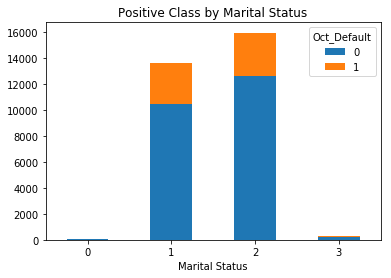

In [45]:
wed = pd.crosstab(accts['MARRIAGE'], accts['Oct_Default'])
wed.plot(kind='bar', stacked=True, title='Positive Class by Marital Status', rot=0)
plt.xlabel("Marital Status")

Text(0.5, 0, 'Marital Status')

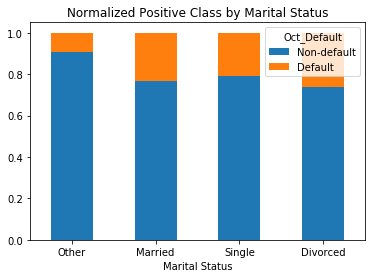

In [47]:
wed.loc[0,:] = wed.loc[0,:]/wed.loc[0,:].sum()
wed.loc[1,:] = wed.loc[1,:]/wed.loc[1,:].sum()
wed.loc[2,:] = wed.loc[2,:]/wed.loc[2,:].sum()
wed.loc[3,:] = wed.loc[3,:]/wed.loc[3,:].sum()
wed = wed.rename(columns={0:'Non-default',1:'Default'})
wed = wed.rename(index={0:'Other',1:'Married',2:'Single',3:'Divorced'})
wed.plot(kind='bar', stacked=True, title='Normalized Positive Class by Marital Status', rot=0)
plt.xlabel("Marital Status")

### We can see that customers who are married or were married are slightly less likely to default than single customers.  This may be correlated with age.  We can look at that next.

### Since 'AGE' is a continuous feature, we can use masking for the distributions.

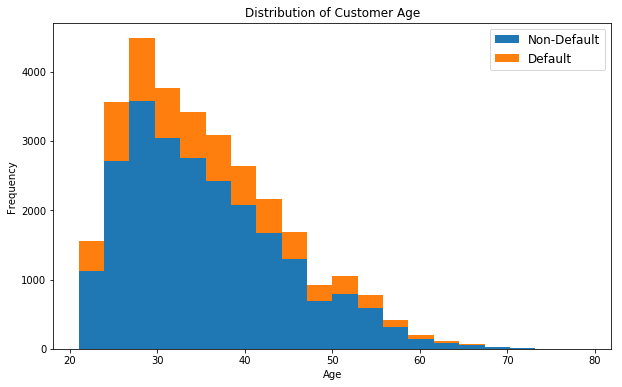

In [51]:
accts_0 = accts[accts['Oct_Default']==0]
accts_1 = accts[accts['Oct_Default']==1]
plt.figure(figsize=(10, 6))
plt.hist([accts_0['AGE'],accts_1['AGE']], stacked=True, bins=20)
plt.title('Distribution of Customer Age')
labels= ['Non-Default', 'Default']
plt.legend(labels, fontsize=12)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

### We can try binning to calculate the risk profiles by age.  My local instructor Douglas Strodtman helped me a great deal on this.  Below we copy our data and create a new column for our age-binning.

In [8]:
accts_copy = accts.copy()

In [9]:
age_bins = [*range(0, accts_copy['AGE'].max()+1, int(accts_copy['AGE'].max()/20))]

In [10]:
for i in range(len(age_bins)-1):
    accts_copy.loc[(accts_copy['AGE'] > age_bins[i]) & (accts_copy['AGE'] <= age_bins[i+1]),'age_bin'] = age_bins[i]

In [11]:
accts_copy[accts_copy['age_bin'].isnull()]

,credit_limit,gender,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Oct_Default,age_bin
ID,,,,,,,,,,,,,,,,,,,,,
18246,440000,1,1,1,79,0,0,0,0,0,...,438187,447543,15715,16519,16513,15800,16531,15677,0,NaN


In [12]:
accts_copy.loc[18246,'age_bin']=72.0                        # Filling a "NaN" value found.

In [13]:
accts_copy['age_bin']=accts_copy['age_bin'].astype(int)     # Convert bins to integer.
accts_copy.head()

,credit_limit,gender,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Oct_Default,age_bin
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,689,0,0,0,0,1,21
2,120000,2,2,2,26,-1,2,0,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,24
3,90000,2,2,2,34,0,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,33
4,50000,2,2,1,37,0,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,36
5,50000,1,2,1,57,-1,0,-1,0,0,...,19146,19131,2000,36681,10000,9000,689,679,0,54


In [14]:
age_accts = pd.crosstab(accts_copy['age_bin'],accts_copy['Oct_Default'])
age_accts.T

age_bin,18,21,24,27,30,33,36,39,42,45,48,51,54,57,60,63,66,69,72
Oct_Default,,,,,,,,,,,,,,,,,,,
0,53,1901,3044,3529,2847,2670,2314,1930,1559,1156,892,668,376,197,95,59,27,13,5
1,14,715,868,873,669,711,621,554,427,381,308,208,133,75,36,21,9,3,4


### Here, we normalize by the counts in the bins and rename the target-classes.

In [15]:
for i in range(len(age_accts)):
    age_accts.iloc[i,:] = age_accts.iloc[i,:]/age_accts.iloc[i,:].sum()

In [16]:
age_accts = age_accts.rename(columns={0:'Non-default',1:'Default'})

Text(0.5, 0, 'AGE (years)')

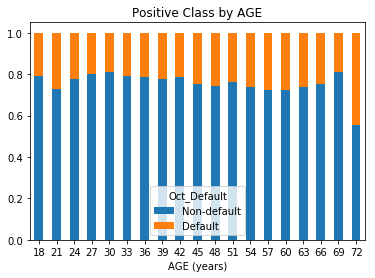

In [18]:
age_accts.plot(kind='bar', stacked=True, title='Positive Class by AGE', rot=0)
plt.xlabel('AGE (years)')

### From the binning-plot, we can see a fairly consistent risk-profile across all age groups.  (The last group had only 8 total accounts, so it may not be very representative of the behavior in that age group.  More research would be needed to clarify this.)

### With this method we can similarly look at risk-profiles based on credit limits.

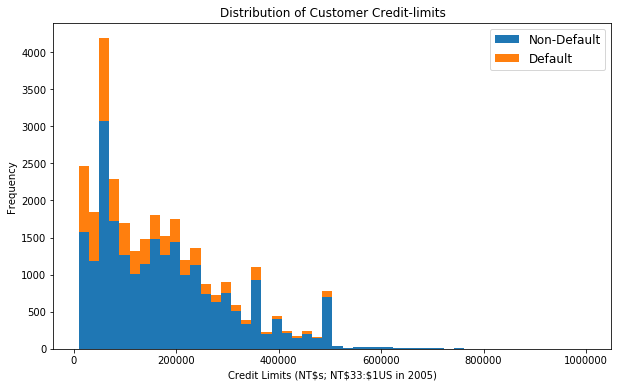

In [73]:
plt.figure(figsize=(10, 6))
plt.hist([accts_0['credit_limit'],accts_1['credit_limit']], stacked=True, bins=50)
plt.title('Distribution of Customer Credit-limits')
labels= ['Non-Default', 'Default']
plt.legend(labels, fontsize=12)
plt.xlabel('Credit Limits (NT$s; NT$33:$1US in 2005)')
plt.ylabel('Frequency')
plt.show()

In [20]:
credit_bins = [*range(0, accts_copy['credit_limit'].max()+1, int(accts_copy['credit_limit'].max()/50))]

In [21]:
for i in range(len(credit_bins)-1):
    accts_copy.loc[(accts_copy['credit_limit'] > credit_bins[i]) & (accts_copy['credit_limit'] <= credit_bins[i+1]),'credit_bin'] = credit_bins[i]

In [22]:
accts_copy['credit_bin']=accts_copy['credit_bin'].astype(int)     # Convert bins to integer.

In [23]:
credit_accts = pd.crosstab(accts_copy['credit_bin'],accts_copy['Oct_Default'])

In [24]:
for i in range(len(credit_accts)):
    credit_accts.iloc[i,:] = credit_accts.iloc[i,:]/credit_accts.iloc[i,:].sum()

In [25]:
credit_accts = credit_accts.rename(columns={0:'Non-default',1:'Default'})

In [26]:
credit_accts = credit_accts.rename(index={20000:20, 40000:40, 60000:60, 80000:80, 100000:100,
                                  120000:120, 140000:140, 160000:160, 180000:180, 200000:200,
                                  220000:220, 240000:240, 260000:260, 280000:280, 300000:300,
                                  320000:320, 340000:340, 360000:360, 380000:380, 400000:400,
                                  420000:420, 440000:440, 460000:460, 480000:480, 500000:500,
                                  520000:520, 540000:540, 560000:560, 580000:580, 600000:600,
                                  620000:620, 640000:640, 660000:660, 680000:680, 700000:700,
                                  720000:720, 740000:740, 760000:760, 780000:780, 980000:980
                                 })

Text(0.5, 0, 'Credit Limit (NT$-000s; NT$33:$1US in 2005)')

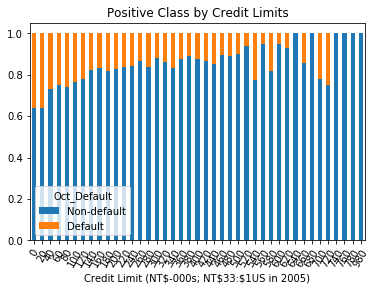

In [28]:
credit_accts.plot(kind='bar', stacked=True, title='Positive Class by Credit Limits', rot=60)
plt.xlabel('Credit Limit (NT$-000s; NT$33:$1US in 2005)')

### We can see that the risk-profile seems to be inversely related to increasing Credit-limits.  (In the credit-bin range above NT\$540,000, the total accounts drops to under 30.)

### Let's look at the 'PAY_0' columns similarly.

Text(0.5, 0, 'Sept-2005 Payment Status')

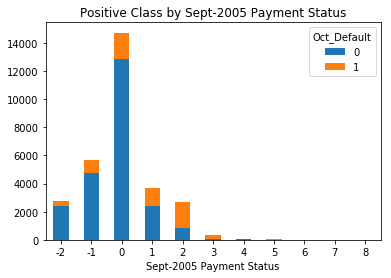

In [154]:
pay_sep = pd.crosstab(accts['PAY_0'], accts['Oct_Default'])
pay_sep.plot(kind='bar', stacked=True, title='Positive Class by Sept-2005 Payment Status', rot=0)
plt.xlabel('Sept-2005 Payment Status')

Text(0.5, 0, 'Sept-2005 Payment Status')

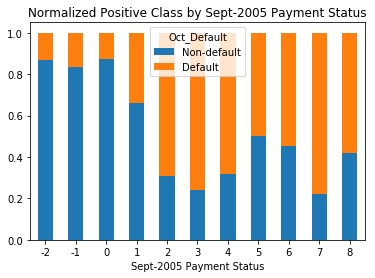

In [157]:
for i in range(-2,9):
    pay_sep.loc[i,:] = pay_sep.loc[i,:]/pay_sep.loc[i,:].sum()
pay_sep = pay_sep.rename(columns={0:'Non-default',1:'Default'})
pay_sep.plot(kind='bar', stacked=True, title='Normalized Positive Class by Sept-2005 Payment Status', rot=0)
plt.xlabel('Sept-2005 Payment Status')

### At least for the '0,' '1' and '2' categories where the total accounts are significant, there seems to be a trend visible.

### Let's continue with the 'PAY_2' to 'PAY_6' columns, starting with August-2005.

Text(0.5, 0, 'Aug-2005 Payment Status')

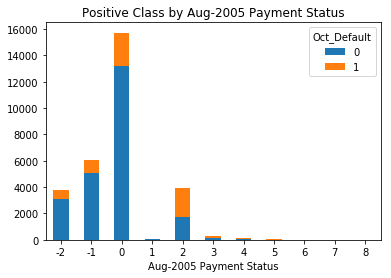

In [155]:
pay_aug = pd.crosstab(accts['PAY_2'], accts['Oct_Default'])
pay_aug.plot(kind='bar', stacked=True, title='Positive Class by Aug-2005 Payment Status', rot=0)
plt.xlabel('Aug-2005 Payment Status')

Text(0.5, 0, 'Aug-2005 Payment Status')

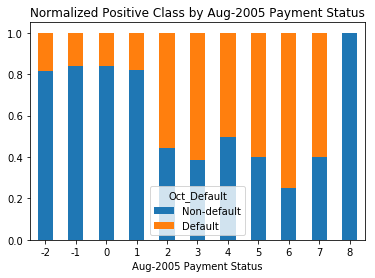

In [158]:
for i in range(-2,9):
    pay_aug.loc[i,:] = pay_aug.loc[i,:]/pay_aug.loc[i,:].sum()
pay_aug = pay_aug.rename(columns={0:'Non-default',1:'Default'})
pay_aug.plot(kind='bar', stacked=True, title='Normalized Positive Class by Aug-2005 Payment Status', rot=0)
plt.xlabel('Aug-2005 Payment Status')

### July-2005 Payment-history status:

Text(0.5, 0, 'Jul-2005 Payment Status')

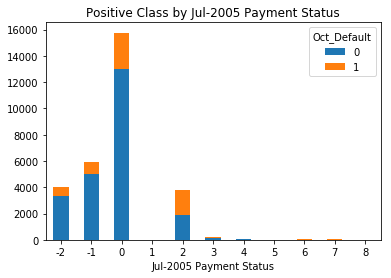

In [164]:
pay_jul = pd.crosstab(accts['PAY_3'], accts['Oct_Default'])
pay_jul.plot(kind='bar', stacked=True, title='Positive Class by Jul-2005 Payment Status', rot=0)
plt.xlabel('Jul-2005 Payment Status')

Text(0.5, 0, 'Jul-2005 Payment Status')

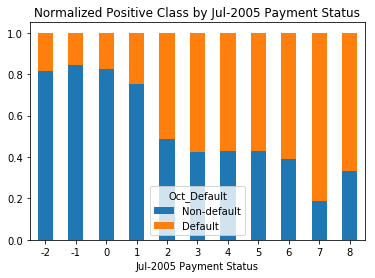

In [165]:
for i in range(-2,9):
    pay_jul.loc[i,:] = pay_jul.loc[i,:]/pay_jul.loc[i,:].sum()
pay_jul = pay_jul.rename(columns={0:'Non-default',1:'Default'})
pay_jul.plot(kind='bar', stacked=True, title='Normalized Positive Class by Jul-2005 Payment Status', rot=0)
plt.xlabel('Jul-2005 Payment Status')

### June-2005 Payment-history status:

Text(0.5, 0, 'Jun-2005 Payment Status')

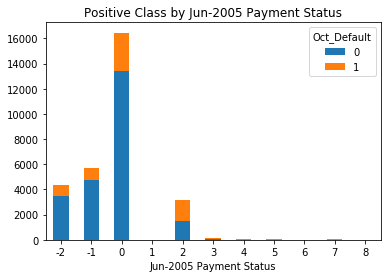

In [166]:
pay_jun = pd.crosstab(accts['PAY_4'], accts['Oct_Default'])
pay_jun.plot(kind='bar', stacked=True, title='Positive Class by Jun-2005 Payment Status', rot=0)
plt.xlabel('Jun-2005 Payment Status')

Text(0.5, 0, 'Jul-2005 Payment Status')

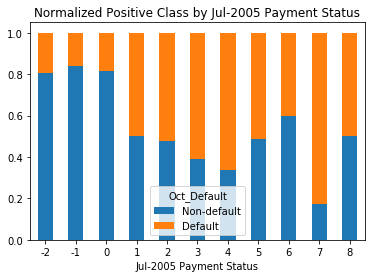

In [167]:
for i in range(-2,9):
    pay_jun.loc[i,:] = pay_jun.loc[i,:]/pay_jun.loc[i,:].sum()
pay_jun = pay_jun.rename(columns={0:'Non-default',1:'Default'})
pay_jun.plot(kind='bar', stacked=True, title='Normalized Positive Class by Jul-2005 Payment Status', rot=0)
plt.xlabel('Jul-2005 Payment Status')

### May-2005 Payment-history status:

Text(0.5, 0, 'May-2005 Payment Status')

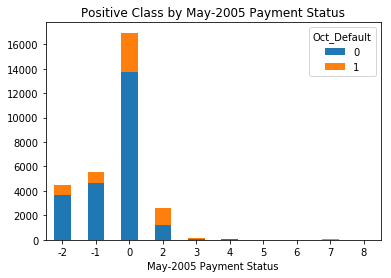

In [168]:
pay_may = pd.crosstab(accts['PAY_5'], accts['Oct_Default'])
pay_may.plot(kind='bar', stacked=True, title='Positive Class by May-2005 Payment Status', rot=0)
plt.xlabel('May-2005 Payment Status')

Text(0.5, 0, 'May-2005 Payment Status')

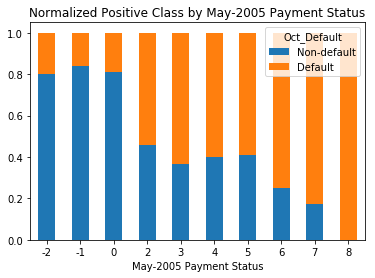

In [170]:
pay_may.loc[-2,:] = pay_may.loc[-2,:]/pay_may.loc[-2,:].sum()
pay_may.loc[-1,:] = pay_may.loc[-1,:]/pay_may.loc[-1,:].sum()
pay_may.loc[0,:] = pay_may.loc[0,:]/pay_may.loc[0,:].sum()
for i in range(2,9):
    pay_may.loc[i,:] = pay_may.loc[i,:]/pay_may.loc[i,:].sum()
pay_may = pay_may.rename(columns={0:'Non-default',1:'Default'})
pay_may.plot(kind='bar', stacked=True, title='Normalized Positive Class by May-2005 Payment Status', rot=0)
plt.xlabel('May-2005 Payment Status')

### April-2005 Payment-history status:

Text(0.5, 0, 'Apr-2005 Payment Status')

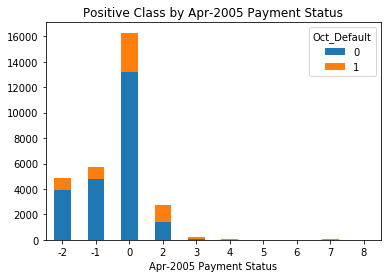

In [171]:
pay_apr = pd.crosstab(accts['PAY_6'], accts['Oct_Default'])
pay_apr.plot(kind='bar', stacked=True, title='Positive Class by Apr-2005 Payment Status', rot=0)
plt.xlabel('Apr-2005 Payment Status')

Text(0.5, 0, 'Apr-2005 Payment Status')

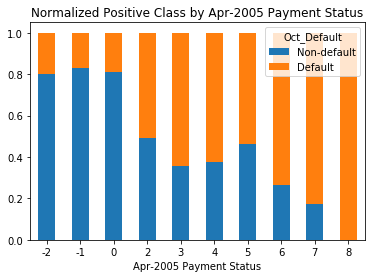

In [172]:
pay_apr.loc[-2,:] = pay_apr.loc[-2,:]/pay_apr.loc[-2,:].sum()
pay_apr.loc[-1,:] = pay_apr.loc[-1,:]/pay_apr.loc[-1,:].sum()
pay_apr.loc[0,:] = pay_apr.loc[0,:]/pay_apr.loc[0,:].sum()
for i in range(2,9):
    pay_apr.loc[i,:] = pay_apr.loc[i,:]/pay_apr.loc[i,:].sum()
pay_apr = pay_apr.rename(columns={0:'Non-default',1:'Default'})
pay_apr.plot(kind='bar', stacked=True, title='Normalized Positive Class by Apr-2005 Payment Status', rot=0)
plt.xlabel('Apr-2005 Payment Status')

### We see the same general pattern for payment-history statuses in each of the six months in the data.

### While our attention rests on the Pay-history statuses, let's quantify the average statuses by month for the two classes.

In [238]:
pay_history_0 = []   # This list contains the average pay-history statuses for the Non-default group.
pay_history_0.append(accts_0['PAY_6'].mean())
pay_history_0.append(accts_0['PAY_5'].mean())
pay_history_0.append(accts_0['PAY_4'].mean())
pay_history_0.append(accts_0['PAY_3'].mean())
pay_history_0.append(accts_0['PAY_2'].mean())
pay_history_0.append(accts_0['PAY_0'].mean())

In [239]:
pay_history_1 = []  # This list contains the average pay-history statuses for the Default group.
pay_history_1.append(accts_1['PAY_6'].mean())
pay_history_1.append(accts_1['PAY_5'].mean())
pay_history_1.append(accts_1['PAY_4'].mean())
pay_history_1.append(accts_1['PAY_3'].mean())
pay_history_1.append(accts_1['PAY_2'].mean())
pay_history_1.append(accts_1['PAY_0'].mean())

### Let's plot these two trends.

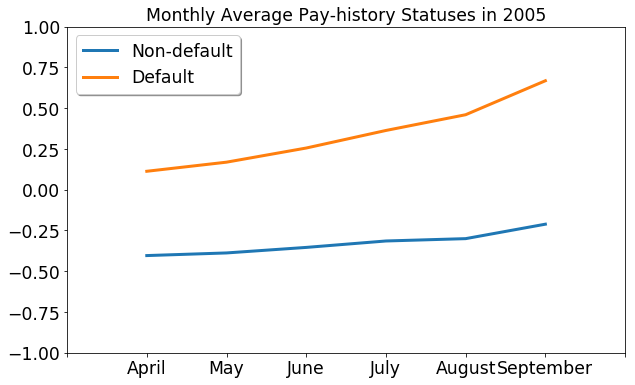

In [250]:
plt.figure(figsize=(10,6))
plt.plot(pay_history_0,lw=3,label='Non-default')
plt.plot(pay_history_1,lw=3,label='Default')
plt.title('Monthly Average Pay-history Statuses in 2005',fontsize='xx-large')
loc,labels = plt.xticks()
plt.ylim(-1,1)
labels=['','April','May','June','July','August','September']
plt.xticks(loc,labels,fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.legend(shadow=True, fontsize='xx-large')

### We can see that the average pay-history statuses show some level of delayed payments for the Default class, while the average pay-history statuses are mostly current for the Non-default class.  This is still the case in September-2005 despite the upward trend for both groups towards an average-delay status.

### Let's look quickly at the distribution for the 'BILL_AMT1' (Sept-2005 Billing) column:

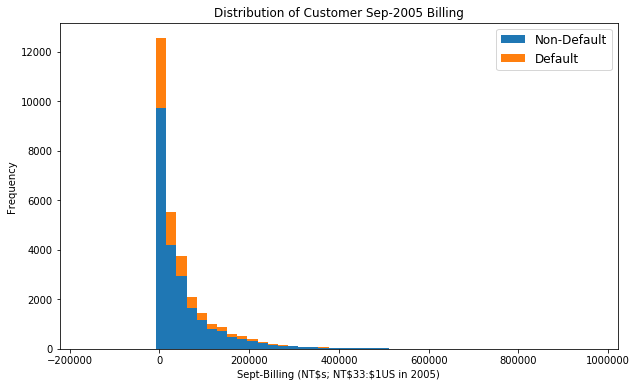

In [173]:
plt.figure(figsize=(10, 6))
plt.hist([accts_0['BILL_AMT1'],accts_1['BILL_AMT1']], stacked=True, bins=50)
plt.title('Distribution of Customer Sep-2005 Billing')
labels= ['Non-Default', 'Default']
plt.legend(labels, fontsize=12)
plt.xlabel('Sept-Billing (NT$s; NT$33:$1US in 2005)')
plt.ylabel('Frequency')
plt.show()

### We see a very tall, very skewed distribution with a long tail.  There are also a large number of negative billing amounts.

### Let's take a closer look at these accounts with negative billing amounts in September-2005, for the Default-class in particular.  This analysis was assisted by my local instructor, Douglas Strodtman.

In [256]:
payment_cols = accts.columns[accts.columns.str.contains('PAY')]
bill_cols = accts.columns[accts.columns.str.contains('BILL')]
accts[(accts.BILL_AMT2<0) & (accts.Oct_Default==1)][[*payment_cols] + [*bill_cols] + ['credit_limit']]

,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,credit_limit
ID,,,,,,,,,,,,,,,,,,,
27,1,-2,-1,-1,-1,-1,0,1000,0,500,0,1000,-109,-425,259,-57,127,-189,60000
174,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,-709,-709,-709,-2898,-3272,-3272,50000
217,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,-946,-946,-946,-946,-946,-946,240000
547,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,-65,-65,-65,-65,-65,-200,220000
654,1,-2,-2,-1,-1,-2,0,200,42000,0,0,0,-200,-200,0,42000,0,0,450000
933,2,2,-1,-1,-1,-1,0,874,0,892,0,594,1989,-8,866,0,892,0,160000
960,-1,-1,-1,0,-1,-1,0,8348,0,23020,2367,3117,1338,-24,8324,5872,23020,2367,250000
1119,1,-2,-2,-2,-2,-2,0,0,0,0,0,0,-150,-150,-150,-150,-150,-150,140000
1664,-2,-2,-2,-2,-2,-2,0,4958,0,763,0,14472,-312,-2479,2479,2479,763,288,500000


### We can see that despite having negative bill amounts in August (127 accounts selected here), at least three accounts in the Oct-Default class made positive payments in September.  Specifically, the account with ID= 28720 may have been anticipating a sizable purchase in the September period.  This all seems highly irregular, yet may be captured in the recognition that negative balances relate to refunds of earlier purchases.  It is difficult to tell.

### Instead of continuing to look at each month separately, let's look at the average billed amounts together and by default-class.

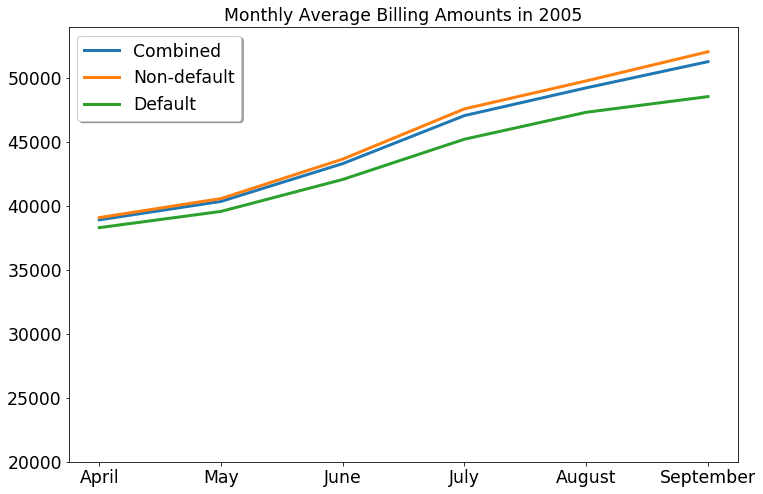

In [193]:
billing_columns=['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4',
                 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1']
plt.figure(figsize=(12,8))
plt.plot(accts[billing_columns].mean(),lw=3,label='Combined')
plt.plot(accts_0[billing_columns].mean(),lw=3,label='Non-default')
plt.plot(accts_1[billing_columns].mean(),lw=3,label='Default')
plt.title('Monthly Average Billing Amounts in 2005',fontsize='xx-large')
loc,labels = plt.xticks()
labels=['April','May','June','July','August','September']
plt.ylim(20000,54000)
plt.xticks(loc,labels,fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.legend(shadow=True, fontsize='xx-large')

### We can see that the Default group is not borrowing a much as the Non-default group as leverage picks up from month to month.

### Let's look at the similar pattern in payment amounts.

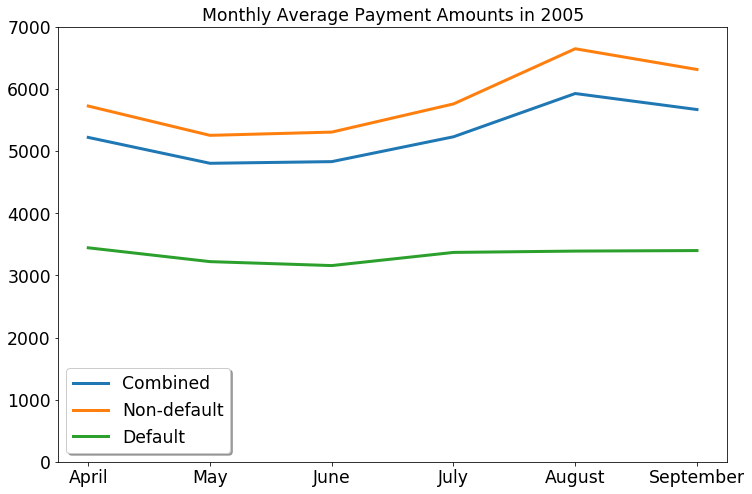

In [196]:
payment_columns=['PAY_AMT6', 'PAY_AMT5', 'PAY_AMT4',
                 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1']
plt.figure(figsize=(12,8))
plt.plot(accts[payment_columns].mean(),lw=3,label='Combined')
plt.plot(accts_0[payment_columns].mean(),lw=3,label='Non-default')
plt.plot(accts_1[payment_columns].mean(),lw=3,label='Default')
plt.title('Monthly Average Payment Amounts in 2005',fontsize='xx-large')
loc,labels = plt.xticks()
plt.ylim(0,7000)
labels=['April','May','June','July','August','September']
plt.xticks(loc,labels,fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.legend(shadow=True, fontsize='xx-large')

### What this shows is that over the same period that borrowing is accelerating, the Non-default group is trying to keep up with payments, but after July-2005, the Default group payments are leveling off.  This may suggest a condition of financial stress.  There is definitely something dramatic happening over this period leading up to October.

### Let's try to quantify this leverage spread between the Default and Non-default groups.  We can do this by calculating the ratio of payments on a given month to billing on the previous month.  The ratios could be appended to an a list for each Default/Non-default  group.  Let's start with the Non-default group list first.

In [221]:
paydown_0 = []

In [222]:
accts_0['pay1_bill2'] = accts_0['PAY_AMT1']/accts_0['BILL_AMT2']
accts_0['pay2_bill3'] = accts_0['PAY_AMT2']/accts_0['BILL_AMT3']
accts_0['pay3_bill4'] = accts_0['PAY_AMT3']/accts_0['BILL_AMT4']
accts_0['pay4_bill5'] = accts_0['PAY_AMT4']/accts_0['BILL_AMT5']
accts_0['pay5_bill6'] = accts_0['PAY_AMT5']/accts_0['BILL_AMT6']

In [223]:
paydown_0.append(accts_0[(accts_0['pay5_bill6']<100.)&(accts_0['pay5_bill6']>-19.)]['pay5_bill6'].mean())
paydown_0.append(accts_0[(accts_0['pay4_bill5']<100.)&(accts_0['pay4_bill5']>-19.)]['pay4_bill5'].mean())
paydown_0.append(accts_0[(accts_0['pay3_bill4']<100.)&(accts_0['pay3_bill4']>-19.)]['pay3_bill4'].mean())
paydown_0.append(accts_0[(accts_0['pay2_bill3']<100.)&(accts_0['pay2_bill3']>-19.)]['pay2_bill3'].mean())
paydown_0.append(accts_0[(accts_0['pay1_bill2']<100.)&(accts_0['pay1_bill2']>-19.)]['pay1_bill2'].mean())

### Above, we are trimming the extreme values before appending to our list.

In [224]:
paydown_0

[0.37735412241266086,
 0.35876078831077757,
 0.3576314222547569,
 0.3836337352201829,
 0.37505630352244274]

### We see the average paydown rates for the Non-default group above.

### Let's calculate the same for the Default group.

In [216]:
paydown_1 = []

In [217]:
accts_1['pay1_bill2'] = accts_1['PAY_AMT1']/accts_1['BILL_AMT2']
accts_1['pay2_bill3'] = accts_1['PAY_AMT2']/accts_1['BILL_AMT3']
accts_1['pay3_bill4'] = accts_1['PAY_AMT3']/accts_1['BILL_AMT4']
accts_1['pay4_bill5'] = accts_1['PAY_AMT4']/accts_1['BILL_AMT5']
accts_1['pay5_bill6'] = accts_1['PAY_AMT5']/accts_1['BILL_AMT6']

In [219]:
paydown_1.append(accts_1[(accts_1['pay5_bill6']<10.)&(accts_1['pay5_bill6']>-10.)]['pay5_bill6'].mean())
paydown_1.append(accts_1[(accts_1['pay4_bill5']<10.)&(accts_1['pay4_bill5']>-10.)]['pay4_bill5'].mean())
paydown_1.append(accts_1[(accts_1['pay3_bill4']<10.)&(accts_1['pay3_bill4']>-10.)]['pay3_bill4'].mean())
paydown_1.append(accts_1[(accts_1['pay2_bill3']<10.)&(accts_1['pay2_bill3']>-10.)]['pay2_bill3'].mean())
paydown_1.append(accts_1[(accts_1['pay1_bill2']<10.)&(accts_1['pay1_bill2']>-10.)]['pay1_bill2'].mean())

In [209]:
paydown_1

[0.23169509582351852,
 0.2378656436892692,
 0.21605742173297626,
 0.22134795114494205,
 0.23158225104332603]

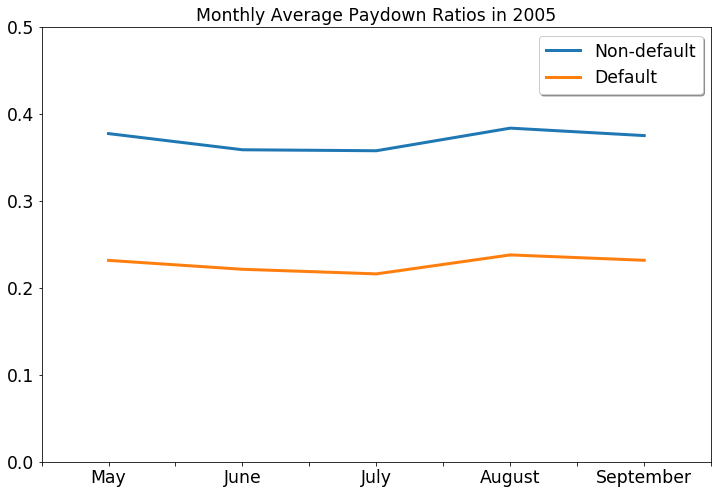

In [228]:
plt.figure(figsize=(12,8))
plt.plot(paydown_0,lw=3,label='Non-default')
plt.plot(paydown_1,lw=3,label='Default')
plt.title('Monthly Average Paydown Ratios in 2005',fontsize='xx-large')
loc,labels = plt.xticks()
plt.ylim(0,0.5)
labels=['','May','','June','','July','','August','','September']
plt.xticks(loc,labels,fontsize='xx-large')
plt.yticks(fontsize='xx-large')
plt.legend(shadow=True, fontsize='xx-large')

### We can see that the paydown ratios are surprisingly consistent and dominated by the payment amounts month-over-month.  This highlights that the rate of borrowing by the Default group was also flattening over August- and September-2005.

### We might expect there to be significant interaction between billing and payment amounts.  Also, there is a striking separation in the paydown rates of the two classes, a separation in the order of the percentage below.

In [235]:
print('The paydown rate of the Default-group as a percentage of the paydown rate of the Non-default group:',
      np.mean(paydown_1)/np.mean(paydown_0))

The paydown rate of the Default-group as a percentage of the paydown rate of the Non-default group: 0.6146221164813221


## Continue to Notebook-3, Feature Engineering.

### After looking at normalized stacked bar charts representing the two classes, we looked at month-over-month trends of payment-history statuses, billing amounts and paydown rates.  We saw a general worsening in borrowing leverage and signs of financial stress.  We also found some anomalous patterns with negative balances that could be attributed to returns/refund activity.  

### Now we are interested in engineering some relevant features in advance of modeling and analysis.  Some anticipated multicollinearity may become apparent as we progress through our predictive workflow.  Our end goal is to choose the most robust model to deploy in production if approved.